In [1]:
import torch
from fastai.vision import Path,get_image_files,open_image,get_transforms,ImageDataBunch,imagenet_stats,cnn_learner,models,ClassificationInterpretation
import pandas as pd
import numpy as np
import warnings
from fastai.metrics import error_rate


warnings.filterwarnings('ignore')
np.random.seed(2)

In [2]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [3]:
#Setting path for dataset
base_path = Path('/kaggle/input/fashion-product-images-small/myntradataset')
images_path = base_path/'images'
base_path.ls()

[PosixPath('/kaggle/input/fashion-product-images-small/myntradataset/styles.csv'),
 PosixPath('/kaggle/input/fashion-product-images-small/myntradataset/images')]

# Training the model

In [4]:
df_fine_tuned = pd.read_csv('/kaggle/input/fashion-label-training/top_65_catagory.csv')
df_fine_tuned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29324 entries, 0 to 29323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    29324 non-null  object
 1   label   29324 non-null  object
dtypes: object(2)
memory usage: 458.3+ KB


In [5]:
df_fine_tuned.head()

,name,label
0,39386.jpg,Jeans-Men-Bottomwear-Apparel
1,21379.jpg,Track Pants-Men-Bottomwear-Apparel
2,53759.jpg,Tshirts-Men-Topwear-Apparel
3,1855.jpg,Tshirts-Men-Topwear-Apparel
4,30805.jpg,Shirts-Men-Topwear-Apparel


In [6]:
#Printing images that don't exist from the dataframe
invalid_img = []
for idx,value in enumerate(df_fine_tuned.name):
    path = images_path/str(value)
    if not path.is_file():
        invalid_img.append(idx)
        print(idx,path)
invalid_img

[]

In [7]:
#Printing distinct catagories
len(df_fine_tuned.label.unique())

65

In [8]:
df_fine_tuned.groupby('label')['name'].count().nlargest(100)

label
Tshirts-Men-Topwear-Apparel                         4223
Shirts-Men-Topwear-Apparel                          2289
Men-Shoes-Footwear                                  2286
Kurtas-Women-Topwear-Apparel                        1586
Sports Shoes-Footwear                               1579
                                                    ... 
Shorts-Boys-Bottomwear-Apparel                        46
Night suits-Men-Loungewear and Nightwear-Apparel      43
Laptop Bag-Unisex-Bags-Accessories                    43
Backpacks-Men-Bags-Accessories                        42
Jackets-Women-Topwear-Apparel                         38
Name: name, Length: 65, dtype: int64

Shirts-Men-Topwear-Apparel


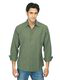

In [9]:
print(df_fine_tuned['label'][4])
open_image(base_path/'images'/df_fine_tuned['name'][4])

In [10]:
#Applying image augmentation - rotate, flip, zoom, lighting
tfms= get_transforms(max_rotate=25,do_flip=True,max_zoom=1.1,max_lighting=0.4)


In [11]:
# loading data to model and start training
data_fine_tuned = ImageDataBunch.from_df(images_path, df_fine_tuned, ds_tfms=tfms,size=60, bs=64).normalize(imagenet_stats)
learn_fine_tuned = cnn_learner(data_fine_tuned, models.resnet101, metrics=error_rate)
learn_fine_tuned.fit_one_cycle(4)
learn_fine_tuned.model_dir = "/kaggle/working"
#saving the model as pytorch
learn_fine_tuned.save('Fashion_model-65-category')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.758628,1.441168,0.364939,01:27
1,1.242788,0.924980,0.288199,01:09
2,1.018338,0.807193,0.254263,01:08
3,0.883785,0.784603,0.238574,01:08


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


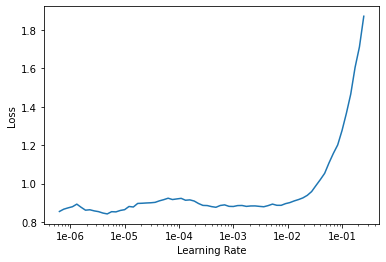

In [12]:
#Finding learning rate to fine tune the model
learn_fine_tuned.lr_find()
learn_fine_tuned.recorder.plot()

In [14]:
#Setting learning rate and retraining the model 
learn_fine_tuned.unfreeze()
learn_fine_tuned.fit_one_cycle(6, max_lr=slice(1e-06,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.806694,0.675473,0.225102,01:15
1,0.761973,0.630088,0.208049,01:14
2,0.650562,0.544572,0.180764,01:14
3,0.573321,0.521197,0.175307,01:15
4,0.510194,0.486986,0.165246,01:13
5,0.470758,0.484864,0.165757,01:14


In [15]:
#Understanding on what the model learned 
interp = ClassificationInterpretation.from_learner(learn_fine_tuned)

losses,idxs = interp.top_losses()

len(data_fine_tuned.valid_ds)==len(losses)==len(idxs)

interp.most_confused(min_val=2)

[('Men-Shoes-Footwear', 'Sports Shoes-Footwear', 57),
 ('Shirts-Women-Topwear-Apparel', 'Tshirts-Women-Topwear-Apparel', 54),
 ('Kurtis-Women-Topwear-Apparel', 'Kurtas-Women-Topwear-Apparel', 33),
 ('Sports Shoes-Footwear', 'Men-Shoes-Footwear', 33),
 ('Watches-Women-Watches-Accessories', 'Watches-Men-Watches-Accessories', 33),
 ('Tshirts-Women-Topwear-Apparel', 'Shirts-Women-Topwear-Apparel', 26),
 ('Casual Shoes-Unisex-Shoes-Footwear', 'Men-Shoes-Footwear', 25),
 ('Kurtas-Women-Topwear-Apparel', 'Shirts-Women-Topwear-Apparel', 20),
 ('Shirts-Women-Topwear-Apparel', 'Kurtas-Women-Topwear-Apparel', 20),
 ('Tshirts-Men-Topwear-Apparel', 'Shirts-Men-Topwear-Apparel', 18),
 ('Casual Shoes-Women-Shoes-Footwear', 'Men-Shoes-Footwear', 16),
 ('Casual Shoes-Women-Shoes-Footwear', 'Women-Shoes-Footwear', 16),
 ('Watches-Men-Watches-Accessories', 'Watches-Women-Watches-Accessories', 15),
 ('Watches-Unisex-Watches-Accessories', 'Watches-Men-Watches-Accessories', 15),
 ('Flip Flops-Women-Flip Flo

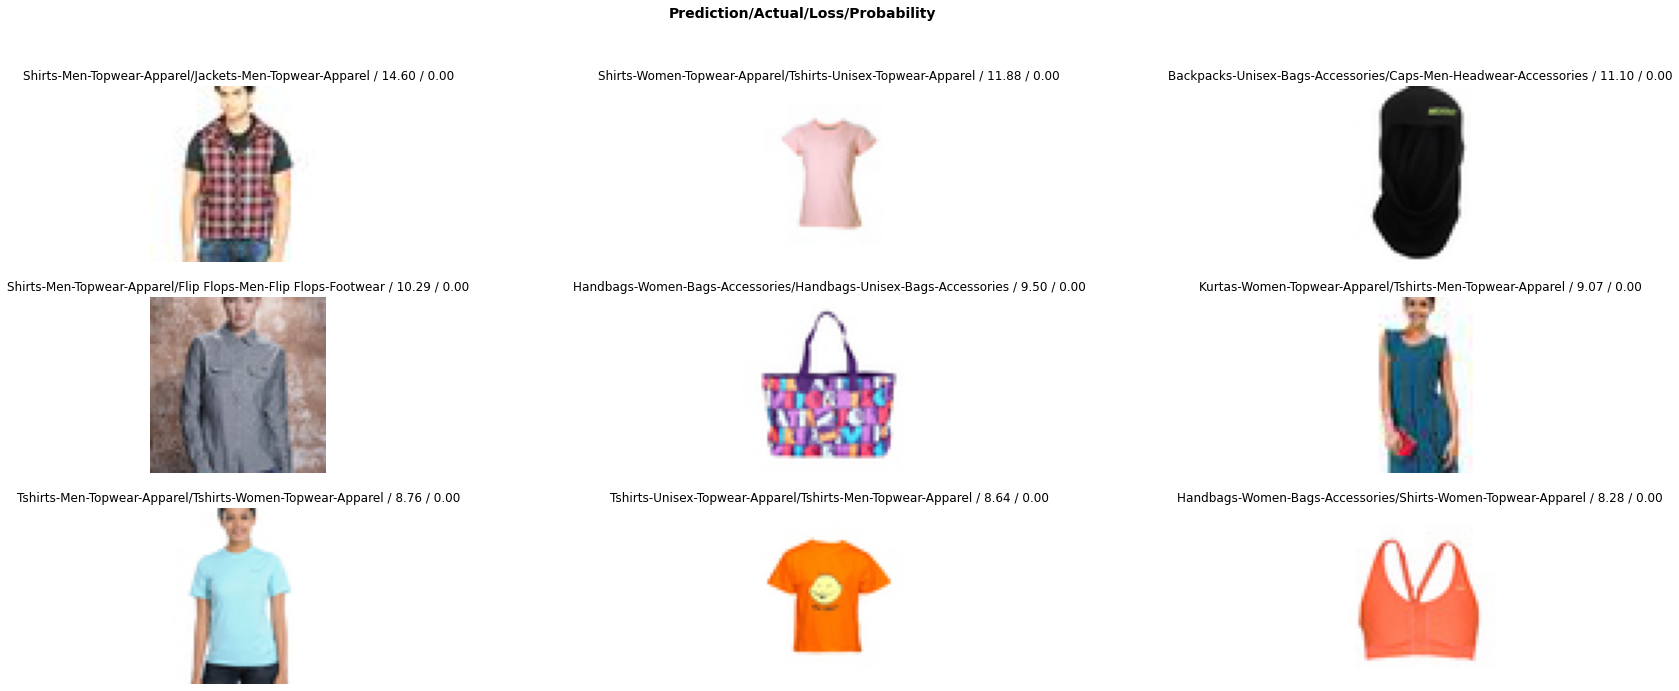

In [16]:
#Viewing top losses interpreted from the model
interp.plot_top_losses(9, figsize=(30,11))

Tshirts-Men-Topwear-Apparel


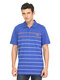

In [17]:
#Testing a image
print(df_fine_tuned['label'][4488])
test = open_image(base_path/'images'/df_fine_tuned['name'][4488])
test

In [18]:
#Running inference
learn_fine_tuned.predict(test)

(Category tensor(56),
 tensor(56),
 tensor([3.9864e-09, 9.1519e-08, 2.1259e-08, 6.9544e-09, 4.4557e-09, 8.2737e-10,
         2.3953e-08, 5.0128e-09, 5.2530e-10, 1.0720e-10, 4.0177e-09, 8.0788e-10,
         1.1494e-08, 8.3009e-09, 4.0391e-09, 1.6461e-10, 3.4160e-11, 1.1191e-07,
         7.4249e-09, 5.0963e-10, 2.6472e-09, 1.7479e-10, 1.0708e-06, 6.1277e-08,
         1.6727e-08, 3.5074e-10, 7.1850e-09, 3.6141e-11, 3.1465e-09, 1.7432e-09,
         1.4128e-09, 2.2742e-10, 1.3262e-10, 1.6872e-08, 1.7235e-09, 2.5166e-05,
         3.6267e-06, 3.4471e-10, 3.8651e-10, 2.5602e-10, 7.1917e-11, 2.2836e-08,
         2.7345e-11, 4.5155e-08, 2.4430e-09, 7.1424e-09, 5.8474e-05, 2.0913e-07,
         6.0849e-06, 7.9986e-09, 1.2901e-07, 1.3463e-08, 1.0220e-09, 2.5487e-09,
         2.0343e-10, 5.3431e-08, 9.9988e-01, 2.3502e-08, 1.9730e-05, 9.3967e-10,
         2.8191e-09, 1.0820e-08, 1.6238e-08, 1.2106e-07, 4.6691e-11]))

In [19]:
#Predicted class 
data_fine_tuned.classes[56]

'Tshirts-Men-Topwear-Apparel'

In [20]:
#list of labels 
data_fine_tuned.classes

['Backpacks-Men-Bags-Accessories',
 'Backpacks-Unisex-Bags-Accessories',
 'Belts-Men-Belts-Accessories',
 'Belts-Women-Belts-Accessories',
 'Capris-Women-Bottomwear-Apparel',
 'Caps-Men-Headwear-Accessories',
 'Caps-Unisex-Headwear-Accessories',
 'Casual Shoes-Unisex-Shoes-Footwear',
 'Casual Shoes-Women-Shoes-Footwear',
 'Clutches-Women-Bags-Accessories',
 'Dresses-Girls-Dress-Apparel',
 'Duffel Bag-Unisex-Bags-Accessories',
 'Flip Flops-Men-Flip Flops-Footwear',
 'Flip Flops-Unisex-Flip Flops-Footwear',
 'Flip Flops-Women-Flip Flops-Footwear',
 'Handbags-Unisex-Bags-Accessories',
 'Handbags-Women-Bags-Accessories',
 'Jackets-Men-Topwear-Apparel',
 'Jackets-Women-Topwear-Apparel',
 'Jeans-Men-Bottomwear-Apparel',
 'Jeans-Women-Bottomwear-Apparel',
 'Kurta Sets-Women-Apparel Set-Apparel',
 'Kurtas-Men-Topwear-Apparel',
 'Kurtas-Women-Topwear-Apparel',
 'Kurtis-Women-Topwear-Apparel',
 'Laptop Bag-Unisex-Bags-Accessories',
 'Leggings-Women-Bottomwear-Apparel',
 'Men-Shoes-Footwear',
 'N

In [21]:
#save model as pytorch
learn_fine_tuned.save('Fashion_model-fine_tuned')

In [22]:
#Saving model as binary format
learn_fine_tuned.path = Path("/kaggle/working")
learn_fine_tuned.export()

In [23]:
#Saving the label as csv file
labels = pd.DataFrame(data={"labels": data_fine_tuned.classes})
labels.to_csv("labels.csv", sep=',',index=False,header=False)